In [26]:
import random
from joblib import dump, load


import numpy as np
import numpy.ma as ma  

import pandas as pd

from scipy.stats import mannwhitneyu


from amp.data_utils.sequence import translate_peptide
from amp.utils import phys_chem_propterties as phys
from amp.inference import HydrAMPGenerator
from amp.data_utils.sequence import pad, to_one_hot, translate_peptide

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences


# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 6, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [9]:
POS_COUNT = 1319
NEG_COUNT = 1253

In [120]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

palette_models = {  
    'HydrAMP τ=1': '#B80018',
    'HydrAMP τ=2': '#D91115',
    'HydrAMP τ=5': '#660708',         
    'PepCVAE': '#1d3557',
    'Basic': '#B4C5E4',
    'Joker': '#0F5257', #'##49416D',       
#     'AMP-LM': '#588B8B',
#     'Dean-VAE': '#DE6897',
#     'Muller-LSTM': '#73D2DE',
#     'AMP-GAN': '#FA9F42',    
}


TEMPS = {
    'HydrAMP': [1, 2, 5],
    'PepCVAE': [1],
    'Basic': [1],
}

In [11]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [12]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_molarweight(x:list):
    h = modlamp.descriptors.GlobalDescriptor(data)
    h.calculate_MW()
    return list(h.descriptor.flatten())

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())


def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)


def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())

def calculate_alphahelixpropensity(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'levitt_alpha')
    h.calculate_global()
    return list(h.descriptor.flatten())

def calculate_instability_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.instability_index()
    return list(h.descriptor.flatten())

def calculate_hscore(data:list):
    return [phys.helical_search(x) for x in data]


def calculate_hydrophobic_ratio(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.hydrophobic_ratio()
    return list(h.descriptor.flatten())
#     return [phys.helical_search(x) for x in data]

def calculate_boman_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.boman_index()
    return list(h.descriptor.flatten())


In [13]:
def calculate_physchem(peptides, datasets, n):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []
    physchem['alpha'] = []
    physchem['boman'] = []
    physchem['h_score'] = []
    physchem['hydrophobic_ratio'] = []
    physchem['instability'] = []

    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)
        physchem['alpha'] += calculate_alphahelixpropensity(dataset)
        physchem['boman'] += calculate_boman_index(dataset)
        physchem['hydrophobic_ratio'] += calculate_hydrophobic_ratio(dataset)
        physchem['instability'] += calculate_instability_index(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [14]:
def select_peptides(results):
    peptides = np.array([translate_peptide(x) for x in results['new_peptides']]).reshape(64, -1)
    amp = (results['new_amp'] < 0.8).reshape(64, -1)
    mic = results['new_mic'].reshape(64, -1)
    combined = ma.masked_where(amp, mic)
    good = combined.argmax(axis=0)
    good_peptides = peptides[good, list(range(peptides.shape[1]))]
    good_amp = np.array(results['new_amp']).reshape(64, -1).T[list(range(peptides.shape[1])), good]
    good_mic = np.array(results['new_mic']).reshape(64, -1).T[list(range(peptides.shape[1])), good]
    return pd.DataFrame.from_dict({
        'sequence': good_peptides.tolist(), 
        'amp': good_amp.tolist(),
        'mic': good_mic.tolist(),
    }
        )

# Read model

In [15]:
generator = HydrAMPGenerator(
    f'../models/HydrAMP/37/',
    f'../models/HydrAMP/pca_decomposer.joblib',
)    

amp_classifier, mic_classifier = generator._amp_classifier, generator._mic_classifier 

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


## Read & Prepare data

In [16]:
impr0_neg = load(f'../results/z_sigma_improvement_0_NegTest.joblib')
impr2_neg = load(f'../results/z_sigma_improvement_2_NegTest.joblib')
impr5_neg = load(f'../results/z_sigma_improvement_5_NegTest.joblib')
pepcvae_neg = load(f'../results/improvement_NegTest.joblib')['PepCVAE']
basic_neg = load(f'../results/improvement_NegTest.joblib')['Basic']


impr0_pos = load(f'../results/z_sigma_improvement_0_PosTest.joblib')
impr2_pos = load(f'../results/z_sigma_improvement_2_PosTest.joblib')
impr5_pos = load(f'../results/z_sigma_improvement_5_PosTest.joblib')
pepcvae_pos = load(f'../results/improvement_PosTest.joblib')['PepCVAE']
basic_pos = load(f'../results/improvement_PosTest.joblib')['Basic']


impr0_neg = select_peptides(impr0_neg).sequence.tolist()
impr2_neg = select_peptides(impr2_neg).sequence.tolist()
impr5_neg = select_peptides(impr5_neg).sequence.tolist()
pepcvae_neg = select_peptides(pepcvae_neg).sequence.tolist()
basic_neg = select_peptides(basic_neg).sequence.tolist()

impr0_pos = select_peptides(impr0_pos).sequence.tolist()
impr2_pos = select_peptides(impr2_pos).sequence.tolist()
impr5_pos = select_peptides(impr5_pos).sequence.tolist()
pepcvae_pos = select_peptides(pepcvae_pos).sequence.tolist()
basic_pos = select_peptides(basic_pos).sequence.tolist()

In [17]:
def get_preditions(data: list, amp_classifier, mic_classifier):
    classifier_input = pad(to_one_hot(np.array(data)))
    amp = amp_classifier.predict(classifier_input, batch_size=1000)
    mic = mic_classifier.predict(classifier_input, batch_size=1000)
    return amp, mic

def parse_joker_dfs(tsv_path, amp_classifier, mic_classifier):
    df = pd.read_csv(tsv_path, sep='\t')
    df.columns = ['id', 'sequence']
    df['id'] = [str(entry) for entry in df.id]
    df.id = [entry.split('R')[0] for entry in df.id]
    df['amp'], df['mic'] = get_preditions(
        df.sequence,
        amp_classifier,
        mic_classifier
    )    
    return df

negatives = parse_joker_dfs('../data/negatives_test.tsv', amp_classifier, mic_classifier).sequence.tolist()
joker_neg = parse_joker_dfs('../results/negatives_test_joker_output.tsv', amp_classifier, mic_classifier)
positives = parse_joker_dfs('../data/positives_test.tsv', amp_classifier, mic_classifier).sequence.tolist()
joker_pos = parse_joker_dfs('../results/positives_test_joker_output.tsv', amp_classifier, mic_classifier)



In [105]:
test_df = pd.read_csv('../results/negatives_test_joker_output.tsv', sep='\t', header=None)
test_df.columns = ['id', 'seq']

In [109]:
test_df['id'] = [str(entry) for entry in test_df.id]
test_df.id = [entry.split('R')[0] for entry in test_df.id]

In [18]:
idx = joker_neg.groupby(['id'])['mic'].transform(max) == joker_neg['mic']
joker_neg = joker_neg[idx].sequence.tolist()

idx = joker_pos.groupby(['id'])['mic'].transform(max) == joker_pos['mic']
joker_pos = joker_pos[idx].sequence.tolist()

In [19]:
len(joker_pos), len(joker_neg)

(605, 556)

In [20]:
#Load Uniprot
uniprot = list(pd.read_csv('../data/Uniprot_0_25_test.csv').Sequence)
uniprot = random.sample(uniprot, 1253)


#Get random peptides
random_gen = modlamp.sequences.Random(1253, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


In [21]:
datasets_0 = {
    'Random': random_peptides, 
    'Uniprot': uniprot, 
    'Non-AMP test data': negatives,
    'AMP test data': positives,
}

datasets_neg = {
    'HydrAMP τ=0': impr0_neg,
    'HydrAMP τ=2': impr2_neg,
    'HydrAMP τ=5': impr5_neg,        
    'PepCVAE': pepcvae_neg,
    'Basic': basic_neg,
    'Joker': joker_neg,
}

datasets_pos = {
    'HydrAMP τ=0': impr0_pos,
    'HydrAMP τ=2': impr2_pos,
    'HydrAMP τ=5': impr5_pos,        
    'PepCVAE': pepcvae_pos,
    'Basic': basic_pos,
    'Joker': joker_pos,
}


In [22]:
datasets_0_df = calculate_physchem(datasets_0.values(), datasets_0.keys(), 10000)
datasets_neg_df = calculate_physchem(datasets_neg.values(), datasets_neg.keys(), 10000)
datasets_pos_df = calculate_physchem(datasets_pos.values(), datasets_pos.keys(), 10000)

<ipython-input-13-7633cb259203>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))


In [122]:
hydra_color = '#B80018'
pepcvae_color = '#1d3557'
basic_color = '#B4C5E4'

palette_0 = {
    'Random': 'grey', 
    'Uniprot': 'lightgray', 
    'Non-AMP test data': '#66BDBA',
    'AMP test data': '#F7CF8B',
}    
    

properties = {
    'pi': 'Isoelectric point',
    'charge': 'Charge',
    'hydrophobic_ratio': 'Hydrophobic moment',
    'aromacity': 'Aromaticity',
}

datasets = [datasets_0, datasets_neg, datasets_pos]
datasets_df = [datasets_0_df, datasets_neg_df, datasets_pos_df]
palettes = [palette_0, palette_models, palette_models]


In [24]:
def choose_symbol(test_results):
    if test_results > 0.05:
        symbol = 'ns'
    if test_results <= 0.05:
        symbol = '*'
    if test_results <= 0.01:
        symbol = '**'
    if test_results <= 0.001:
        symbol = '***'
    return symbol
    

In [43]:
len(impr0_pos), len(impr2_pos), len(impr5_pos), len(pepcvae_pos), len(basic_pos), len(joker_pos)

(1319, 1319, 1319, 1319, 1319, 605)

In [44]:
len(impr0_neg), len(impr2_neg), len(impr5_neg), len(pepcvae_neg), len(basic_neg), len(joker_neg)

(1253, 1253, 1253, 1253, 1253, 556)

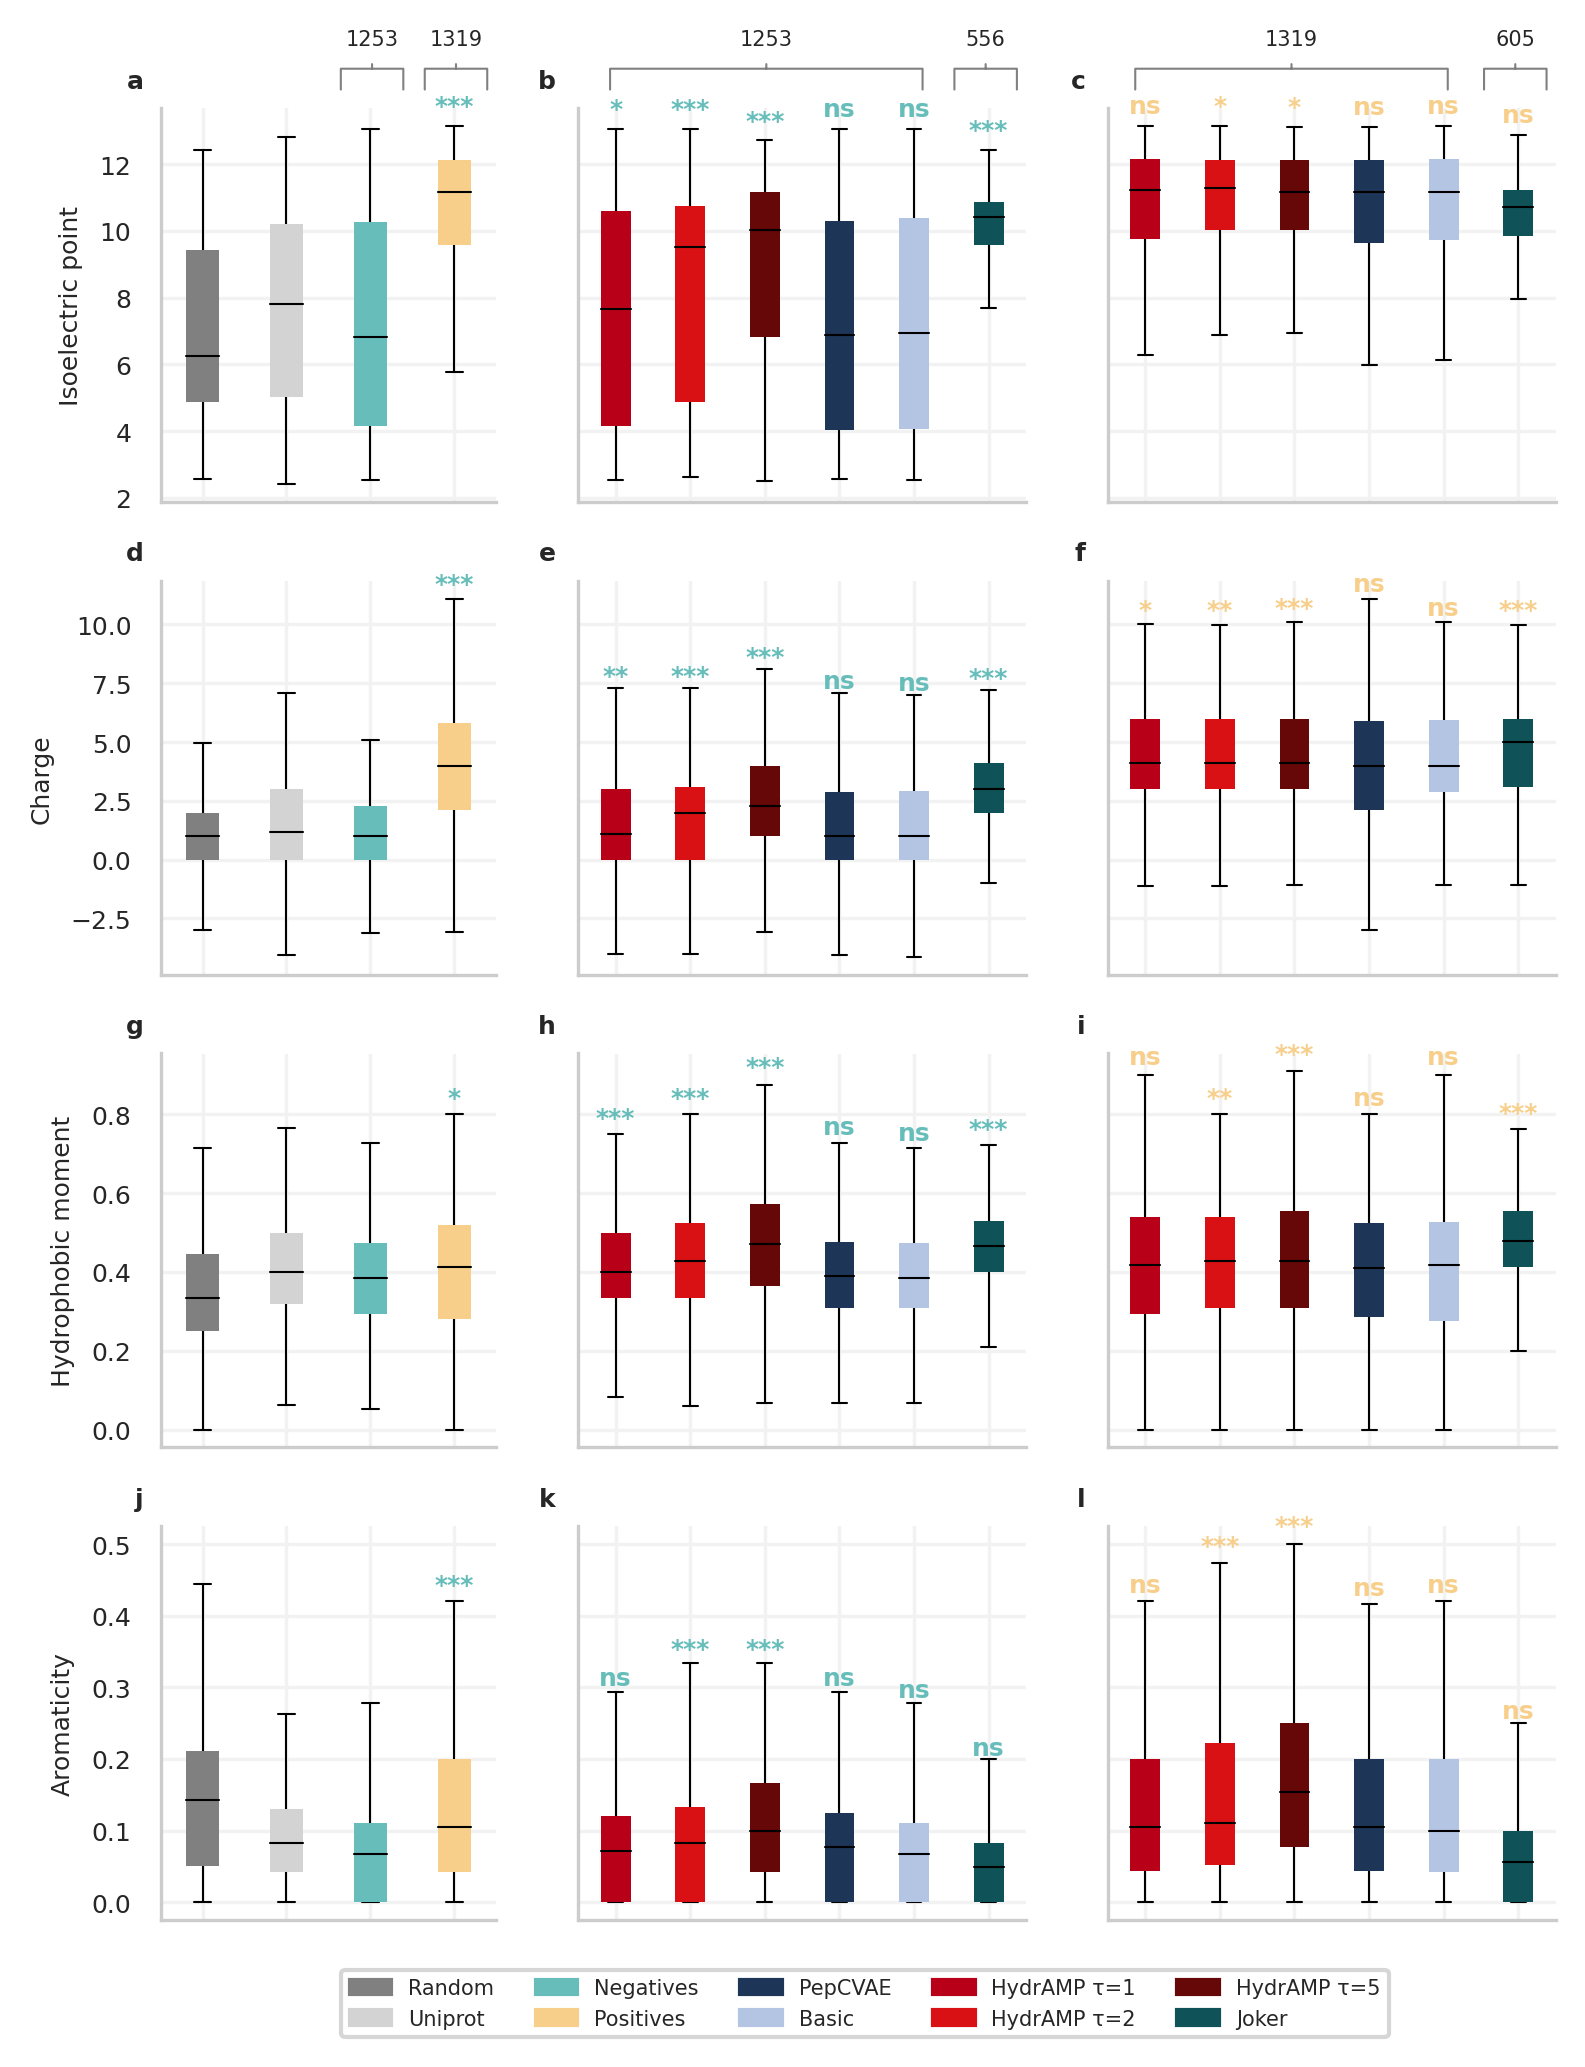

In [128]:
fig, axes = plt.subplots(
    ncols=3, 
    nrows=4,
    figsize=(6, 8),
    dpi=300,
    gridspec_kw={'width_ratios': [1.5, 2, 2]},
    sharey='row'
)


for prop, ax in zip(properties.keys(), axes):
    boxplots = []
    for dataset, physchem, subplot, palette in zip(datasets, datasets_df, ax, palettes):
        
        data = [physchem[physchem['dataset'] == x][prop].tolist() for x in dataset.keys()]
        parts = subplot.boxplot(
            data,
            showfliers=False,
            patch_artist=True,
            boxprops=boxprops,
            flierprops=flierprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            widths=0.4      
        )
        boxplots.append(parts)
        for patch, color in zip(parts['boxes'], palette.values()):
            patch.set_facecolor(color)     
            
        subplot.set_xticklabels([])

## AX0 - random, uniprot, pos, neg

    ax[0].set_ylabel(properties[prop])
    test_results = mannwhitneyu(
        datasets_0_df[datasets_0_df.dataset == 'AMP test data'][prop],
        datasets_0_df[datasets_0_df.dataset == 'Non-AMP test data'][prop], 
        alternative='greater'
    )[1]
    symbol = choose_symbol(test_results)
    

    ax[0].text(
        x=4,
        y=01.03 * boxplots[0]['caps'][7].get_ydata()[0],
        s=symbol,
        ha='center',
        color=palette_0['Non-AMP test data'],
        weight='bold',            
    )    
    
## AX1 - improving negatives     
    for ind, (dataset, cap_id) in enumerate(zip(datasets[1].keys(), [x for x in range(1,12,2)])):

        test_results = mannwhitneyu(
            datasets_neg_df[datasets_neg_df.dataset == dataset][prop],
            datasets_0_df[datasets_0_df.dataset == 'Non-AMP test data'][prop], 
            alternative='greater'
        )[1]
        symbol = choose_symbol(test_results)
    
    
        ax[1].text(
            x=ind+1,
            y=1.03 * boxplots[1]['caps'][cap_id].get_ydata()[0],
            s=symbol,
            ha='center',
            color=palette_0['Non-AMP test data'],
            weight='bold',            
        )
    
## AX2 - improving positives    
    for ind, (dataset, cap_id) in enumerate(zip(datasets[2].keys(), [x for x in range(1,12,2)])):
        test_results = mannwhitneyu(
            datasets_pos_df[datasets_pos_df.dataset == dataset][prop],
            datasets_0_df[datasets_0_df.dataset == 'AMP test data'][prop], 
            alternative='greater'
        )[1]
        symbol = choose_symbol(test_results)
    
        ax[2].text(
            x=ind+1,
            y=1.03 * boxplots[2]['caps'][cap_id].get_ydata()[0],
            s=symbol,
            ha='center',
            color=palette_0['AMP test data'],
            weight='bold',
        )
    
# LEGEND 
plt.legend(
    handles=[
        mpatches.Patch(color=palette_0['Random'], label='Random'),
        mpatches.Patch(color=palette_0['Uniprot'], label='Uniprot'),  
        mpatches.Patch(color=palette_0['Non-AMP test data'], label='Negatives'),  
        mpatches.Patch(color=palette_0['AMP test data'], label='Positives'),   
        mpatches.Patch(color=palette_models['PepCVAE'], label='PepCVAE'),
        mpatches.Patch(color=palette_models['Basic'], label='Basic'),          
        mpatches.Patch(color=palette_models['HydrAMP τ=1'], label='HydrAMP τ=1'),
        mpatches.Patch(color=palette_models['HydrAMP τ=2'], label='HydrAMP τ=2'),
        mpatches.Patch(color=palette_models['HydrAMP τ=5'], label='HydrAMP τ=5'),
        mpatches.Patch(color=palette_models['Joker'], label='Joker'),
        
    ], 
    bbox_to_anchor = (0.65, -0.1),
    ncol=5,
)

for i, (label, ax) in enumerate(
    zip(
        ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'],
        [axes[0][0], axes[0][1], axes[0][2],
        axes[1][0], axes[1][1], axes[1][2],
        axes[2][0], axes[2][1], axes[2][2],
        axes[3][0], axes[3][1], axes[3][2],
        ]
    )
):
    ax.annotate(label, xy=(-0.05, 1.1), xycoords='axes fraction',
      fontweight='bold', va='top', ha='right')

    
    

# le brackets

axes[0][0].annotate(NEG_COUNT, xy=(0.63, 1.1), xytext=(0.63, 1.15), xycoords='axes fraction', 
            fontsize=5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', color='grey', lw=0.5))


axes[0][0].annotate(POS_COUNT, xy=(0.88, 1.1), xytext=(0.88, 1.15), xycoords='axes fraction', 
            fontsize=5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', color='grey', lw=0.5))



axes[0][1].annotate(NEG_COUNT, xy=(0.42, 1.1), xytext=(0.42, 1.15), xycoords='axes fraction', 
            fontsize=5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1', color='grey', lw=0.5)) 

axes[0][1].annotate(len(joker_neg), xy=(0.91, 1.1), xytext=(0.91, 1.15), xycoords='axes fraction', 
            fontsize=5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', color='grey', lw=0.5))


axes[0][2].annotate(POS_COUNT, xy=(0.41, 1.1), xytext=(0.41, 1.15), xycoords='axes fraction', 
            fontsize=5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1', color='grey', lw=0.5))    

axes[0][2].annotate(len(joker_pos), xy=(0.91, 1.1), xytext=(0.91, 1.15), xycoords='axes fraction', 
            fontsize=5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', color='grey', lw=0.5))


# fig.tight_layout()
fig.savefig("../figures/Fig3-Wilcox.svg")
fig.savefig("../../hydramp_revision/figures/Fig3-Wilcox.pdf", bbox_inches="tight")

# plt.show()
# fig.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
# print('HydrAMP τ=0')
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=0']['pi'].describe()

In [ ]:
print('HydrAMP τ=2')
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=2']['pi'].describe()

In [ ]:
print('HydrAMP τ=5')
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=5']['pi'].describe()

In [ ]:
print('AMP test data')
datasets_0_df[datasets_0_df.dataset == 'AMP test data']['pi'].describe()

In [ ]:
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=0']['charge'].describe()

In [ ]:
datasets_0_df[datasets_0_df.dataset == 'AMP test data']['charge'].describe()